In [88]:
import pandas as pd
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [89]:
#正确版本

# To find the estimated removed days T: number of first day infected = number of removed at some day,
# so that we can calculate gamma as 1/T
# Parameter: 'infected' represents the I(t) column; 'removed' represents the R(t) column 
def find_T(infected, removed):
    for r in removed:
        if infected.iloc[0] == r:
            print("number of days be removed: ", list(removed).index(r))

In [90]:
#data:3/31-6/11, I(t)无累积
dt = pd.read_excel(r'/Users/xuqidi/Desktop/sars_clean4.xlsx')
dt

,Date,Country,Cumulative number of case(s),Number of deaths,Number recovered,new cases per day,I(t),R(t),R(t+1)-R(t)
0,2003-03-31,"Hong Kong SAR, China",530,13,20,155,497,33,58
1,2003-04-01,"Hong Kong SAR, China",685,16,75,23,594,91,14
2,2003-04-02,"Hong Kong SAR, China",708,16,89,26,603,105,11
3,2003-04-03,"Hong Kong SAR, China",734,17,99,27,618,116,10
4,2003-04-04,"Hong Kong SAR, China",761,17,109,39,635,126,9
...,...,...,...,...,...,...,...,...,...
68,2003-06-07,"Hong Kong SAR, China",1752,286,1360,0,106,1646,5
69,2003-06-08,"Hong Kong SAR, China",1752,287,1364,1,101,1651,2
70,2003-06-09,"Hong Kong SAR, China",1753,288,1365,1,100,1653,5
71,2003-06-10,"Hong Kong SAR, China",1754,290,1368,0,96,1658,0


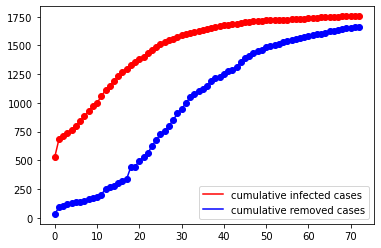

In [91]:
# plot the graph for cumulative number of cases and cumulative removed cases
time = range(len(dt))
dt['t'] = time
cumulative_infected = dt['Cumulative number of case(s)']
cumulative_removed = dt['R(t)']
plt.plot(time ,cumulative_infected ,"r", label = 'cumulative infected cases')
plt.plot(time,cumulative_removed, 'b', label = 'cumulative removed cases' )
plt.scatter(time ,cumulative_infected, c = 'r')
plt.scatter(time,cumulative_removed, c = 'b')
plt.legend()
plt.show()

In [92]:

find_T(dt['Cumulative number of case(s)'], dt['R(t)'])
        
# we can see that T which is the estimated number of days to be removed is 21, so gamma = 1/21

number of days be removed:  21


In [93]:
# To use least square method calculating the best S0 and beta
# Paramater: 'I0' represents the initial value of I(t); 'R0' represents the intial value of R(t); 
#            'I' represents the whole I(t) column; 'R' represents the whole R(t) column; 'gamma' represents gamma=1/T
def leastsq(I0, R0, I, R, gamma):
    res = {}
    pre_min = float('inf')
    for S0 in range(800, 1801, 1): # 800 和1801之间每一个都试一次
        for beta in np.arange(6e-5, 1.8e-4 + 1e-7,1e-7 ): # 6*10^-5 和 1.8*10^-4 + 1*10^-7之间，每10^-7试一次）
            S = S0+I0+R0-I-R # 计算出每天对应的S值
            I_hat = I0 + S0 - S + gamma / beta * np.log(S / S0) #求微分方程dI/dS得出
            re = I_hat - I
            SSE = re.dot(re.T) #最小二乘法
            
            if SSE < pre_min:
                pre_min = SSE
                res = {'S0': S0, 'beta': beta}
    print(res)

# using initial value as 3/31/2003, and gamma = 1/21
leastsq(497, 33, np.array(dt['I(t)']), np.array(dt['R(t)']), 1/21)

/Users/xuqidi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log
  # Remove the CWD from sys.path while we load stuff.
/Users/xuqidi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.


{'S0': 1268, 'beta': 9.420000000000083e-05}


[497.         533.01928354 568.30232943 602.33287344 634.61246118
 664.68099666 692.13484638 716.64100475 737.94647873 755.88250452
 770.36383846 781.3837845  789.00593601 793.35371639 794.59879011
 792.94929261 788.63861587 781.91527219 773.03414765 762.24927772
 749.80814104 735.94737233 720.8897388  704.84218502 687.99473375
 670.52013886 652.57401419 634.29538431 615.80749336 597.21879327
 578.62403174 560.10538354 541.73358286 523.56902648 505.66282706
 488.05780342 470.78940143 453.88653926 437.37238066 421.26503535
 405.57819071 390.32167894 375.50198422 361.12269522 347.18490451
 333.68756746 320.62781435 308.00122993 295.80209731 284.02361164
 272.65807052 261.69703803 251.1314883  240.95193286 231.14852909
 221.71117505 212.62959284 203.89339893 195.49216523 187.41547238
 179.65295387 172.19433417 165.02946138 158.14833368 151.54112183
 145.19818776 139.11009996 133.26764422 127.66183387 122.28391617]


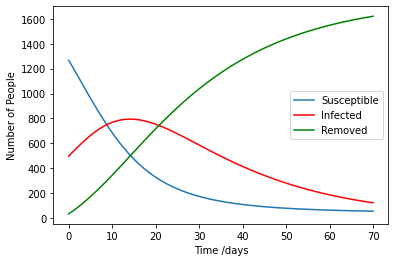

In [97]:
t = np.linspace(0,70,70)
S0 = 1268
beta = 9.420000000000083e-05 
gamma = 1/21
R0 = 33
I0 = 497
N = S0+R0+I0

# To solve the SIR model differential equations
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I
    dIdt = beta * S * I - gamma * I 
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

y0 = S0, I0, R0
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta, gamma))
S, I, R = ret.T

print(I)
plt.plot(t, S, label='Susceptible')
plt.plot(t, I, 'r', label='Infected')
plt.plot(t, R, 'g', label='Removed')
plt.xlabel('Time /days')
plt.ylabel('Number of People')
plt.legend(loc = 'right')

plt.show()

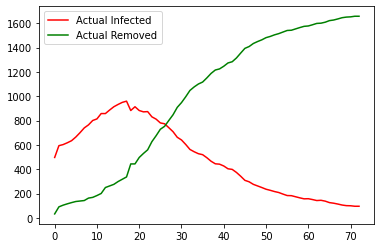

In [98]:
# Actual data for Hongkong, comparing with the model we got

plt.plot(time, dt['I(t)'], 'r', label = 'Actual Infected')
plt.plot(time, dt['R(t)'], 'g', label = 'Actual Removed')
plt.legend()
plt.show()


In [100]:
# 以下为失败经历: 分为 version 1 单日新增无累积病例和Version 2累积病例，用最小二乘法（least square）来计算最佳参数 beta，gamma

# Version 1: calculte m = beta - gamma using no cumulative data(I(t)) 用sars_clean2 -> I(t)为单日新增无累计
df = pd.read_excel(r'/Users/xuqidi/Desktop/sars_clean2.xlsx')
df

,Unnamed: 0,Unnamed: 0.1,Date,Country,Cumulative number of case(s),Number of deaths,Number recovered,new cases per day,I(t),R(t),R(t+1)-R(t),lnI(t),t
0,0,1,2003-04-01,"Hong Kong SAR, China",685,16,75,23,594,91,14,6.386879,0
1,1,2,2003-04-02,"Hong Kong SAR, China",708,16,89,26,603,105,11,6.401917,1
2,2,3,2003-04-03,"Hong Kong SAR, China",734,17,99,27,618,116,10,6.426488,2
3,3,4,2003-04-04,"Hong Kong SAR, China",761,17,109,39,635,126,9,6.453625,3
4,4,5,2003-04-05,"Hong Kong SAR, China",800,20,115,40,665,135,4,6.499787,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,80,81,2003-07-07,"Hong Kong SAR, China",1755,298,1430,0,27,1728,0,3.295837,80
81,81,82,2003-07-08,"Hong Kong SAR, China",1755,298,1430,0,27,1728,1,3.295837,81
82,82,83,2003-07-09,"Hong Kong SAR, China",1755,298,1431,0,26,1729,0,3.258097,82
83,83,84,2003-07-10,"Hong Kong SAR, China",1755,298,1431,0,26,1729,2,3.258097,83


In [101]:
x = df['t']
y = df['lnI(t)']
#use Least Squares to find the best parameters
ols = sm.OLS(y, sm.add_constant(x))
ols_result = ols.fit()
ols_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 lnI(t)   R-squared:                       0.923
Model:                            OLS   Adj. R-squared:                  0.922
Method:                 Least Squares   F-statistic:                     992.2
Date:                Tue, 30 Nov 2021   Prob (F-statistic):           6.20e-48
Time:                        20:42:22   Log-Likelihood:                -27.829
No. Observations:                  85   AIC:                             59.66
Df Residuals:                      83   BIC:                             64.54
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.3923      0.073    101.195      0.000       7.247       7.538
t             -0.0473      0.002    -31.500      0.000      -0.050      -0.044
==============================================================================
Omnibus:                       15.640   Durbin-Watson:                   0.025
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               17.921
Skew:                          -1.093   Prob(JB):                     0.000128
Kurtosis:                       3.533   Cond. No.                         96.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

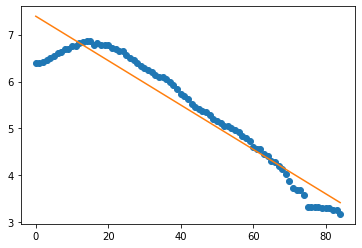

In [102]:
#We can find thatm = -0.0473, ln(I0) = 7.3923
#develop the curve fitting
plt.plot(x, y, 'o')
plt.plot(x, -0.0473*x+7.3923)

In [103]:
# Calculate gamma 
x = df['I(t)']
y = df['R(t+1)-R(t)']

#use Least Squares to find the best parameters
ols = sm.OLS(y, x)
ols_result = ols.fit()
ols_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            R(t+1)-R(t)   R-squared (uncentered):                   0.674
Model:                            OLS   Adj. R-squared (uncentered):              0.670
Method:                 Least Squares   F-statistic:                              173.7
Date:                Tue, 30 Nov 2021   Prob (F-statistic):                    3.73e-22
Time:                        20:42:35   Log-Likelihood:                         -357.03
No. Observations:                  85   AIC:                                      716.1
Df Residuals:                      84   BIC:                                      718.5
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
I(t)           0.0464      0.004     13.181      0.000       0.039       0.053
==============================================================================
Omnibus:                       18.312   Durbin-Watson:                   1.607
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               41.929
Skew:                           0.697   Prob(JB):                     7.86e-10
Kurtosis:                       6.146   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [104]:
# We can see that gamma = 0.0464

# Use m and gamma to calculate beta
beta = -0.0473 + 0.0464
print('beta is', beta)

# the mean removed day T is 1/gamma
T = 1/ 0.0464
print('T is', T)

# Calculte R0, the reproductive rate using gamma and beta
gamma = 0.0464
R0 = beta/gamma
print('R0 is', R0)

#R0 < 1, which is not reasonable. So our initial assumption (S0 = N) is wrong using no cumulative cases. 

beta is -0.000900000000000005
T is 21.551724137931036
R0 is -0.01939655172413804


In [106]:
# Version 2: calculte m = beta - gamma using cumulative data(I(t)) 用sars_clean3 -> I(t)为累计确诊

data = pd.read_excel(r'/Users/xuqidi/Desktop/sars_clean3.xlsx')
data


,Unnamed: 0,Date,Country,Cumulative number of case(s),Number of deaths,Number recovered,new cases per day,I(t),R(t),R(t+1)-R(t),lnI(t),t
0,0,2003-04-01,"Hong Kong SAR, China",685,16,75,23,685,91,14,6.529419,0
1,1,2003-04-02,"Hong Kong SAR, China",708,16,89,26,708,105,11,6.562444,1
2,2,2003-04-03,"Hong Kong SAR, China",734,17,99,27,734,116,10,6.598509,2
3,3,2003-04-04,"Hong Kong SAR, China",761,17,109,39,761,126,9,6.634633,3
4,4,2003-04-05,"Hong Kong SAR, China",800,20,115,40,800,135,4,6.684612,4
...,...,...,...,...,...,...,...,...,...,...,...,...
80,80,2003-07-07,"Hong Kong SAR, China",1755,298,1430,0,1755,1728,0,7.470224,80
81,81,2003-07-08,"Hong Kong SAR, China",1755,298,1430,0,1755,1728,1,7.470224,81
82,82,2003-07-09,"Hong Kong SAR, China",1755,298,1431,0,1755,1729,0,7.470224,82
83,83,2003-07-10,"Hong Kong SAR, China",1755,298,1431,0,1755,1729,2,7.470224,83


In [107]:
x = data['t']
y = data['lnI(t)']

#Use lesat squre to find m = beta - gamma
ols= sm.OLS(y, sm.add_constant(x))
ols_result = ols.fit()
ols_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 lnI(t)   R-squared:                       0.619
Model:                            OLS   Adj. R-squared:                  0.614
Method:                 Least Squares   F-statistic:                     134.8
Date:                Tue, 30 Nov 2021   Prob (F-statistic):           4.54e-19
Time:                        20:43:06   Log-Likelihood:                 38.442
No. Observations:                  85   AIC:                            -72.88
Df Residuals:                      83   BIC:                            -68.00
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.9804      0.033    208.384      0.000       6.914       7.047
t              0.0080      0.001     11.609      0.000       0.007       0.009
==============================================================================
Omnibus:                       13.327   Durbin-Watson:                   0.012
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               14.560
Skew:                          -0.989   Prob(JB):                     0.000689
Kurtosis:                       3.444   Cond. No.                         96.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

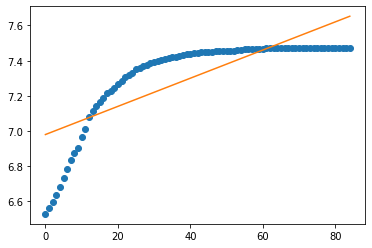

In [108]:
# We can find that m = 0.0080, ln(I0) = 6.9804

#develop the curve fitting
plt.plot(x, y, 'o')
plt.plot(x, 0.0080*x+6.9804)

#the performance of fitting curve isn't good.

In [109]:
#Calculte gamma
x = data['I(t)']
y = data['R(t+1)-R(t)']
ols = sm.OLS(y, x)
ols_result = ols.fit()
ols_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            R(t+1)-R(t)   R-squared (uncentered):                   0.418
Model:                            OLS   Adj. R-squared (uncentered):              0.411
Method:                 Least Squares   F-statistic:                              60.26
Date:                Tue, 30 Nov 2021   Prob (F-statistic):                    1.81e-11
Time:                        20:43:13   Log-Likelihood:                         -381.70
No. Observations:                  85   AIC:                                      765.4
Df Residuals:                      84   BIC:                                      767.8
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
I(t)           0.0116      0.001      7.763      0.000       0.009       0.015
==============================================================================
Omnibus:                       38.948   Durbin-Watson:                   0.943
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               86.971
Skew:                           1.682   Prob(JB):                     1.30e-19
Kurtosis:                       6.639   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [110]:
# We can see that gamma
gamma = 0.0116

# use m and gamma to calculate beta
beta = 0.0080 + gamma
print('beta is', beta)

# the mean removed day = 1/gamma
T = 1/gamma
print('T is', T)

# calculate the reproductive rate R0 = beta/gamma
R0 = beta/gamma
print('R0 is', R0)

# T is too big

beta is 0.0196
T is 86.20689655172414
R0 is 1.6896551724137931


In [ ]:
# our initial assumption that S = N is wrong, will use another method